# Image Classification using Kitti object detection dataset

Import Tensorflow, Keras and OpenCV libraries:

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

import keras_cv
import cv2

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

2024-03-11 16:24:59.889801: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-11 16:25:01.899157: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using TensorFlow backend


Load Kitti dataset into training and validation sets:

In [2]:
# kitti doesnt support as_supervised=True
(training_set, test_set, validation_set), dataset_info = tfds.load('kitti',
                                                         split=['train[:50%]', 'test', 'validation'],
                                                        #  download=True,
                                                         with_info=True,
                                                         )

2024-03-11 16:25:10.642067: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-11 16:25:11.115519: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-11 16:25:11.115604: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-11 16:25:11.118595: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-11 16:25:11.118681: I tensorflow/compile

Transform object-detection dataset to image classification dataset with corect box coordinates.

In [3]:
# a method to transform object-detection dataset to classification dataset
def create_classification_dataset(dataset, take_number, unsample_label, shape):
    unsample_label_counter = 0
    ds = dataset.take(take_number)
    objects = []
    labels = []
    for inputs in ds:
        image = inputs["image"]
        boxes = inputs["objects"]["bbox"]
        classes = inputs["objects"]["type"]
        h,w,ch = inputs["image"].shape
        for box, label in zip(boxes, classes):
            if label==unsample_label:
                unsample_label_counter += 1
            if label!=unsample_label or unsample_label_counter < take_number:
                ymin, xmin, ymax, xmax = box
                ymin, xmin, ymax, xmax = h-int(ymin*h), int(xmin*w), h-int(ymax*h), int(xmax*w)                
                object = image[ymax:ymin, xmin:xmax, :]
                
                if object.shape[1]==0 or object.shape[0]==0:                
                    testimage = np.copy(example["image"])
                    cv2.rectangle(
                        testimage,
                        (xmax, ymax),
                        (xmin, ymin),
                        (255, 0, 0, 0.5),
                        4
                    )
                    keras_cv.visualization.plot_image_gallery(
                        np.array([testimage]), rows=1, cols=1, value_range=(0, 255), show=True, scale=4)
                object = tf.image.resize(object, shape)
                objects.append(object)
                # print(object.shape)
                labels.append(label)
    train_ds = tf.data.Dataset.from_tensor_slices({'image': objects, 'label':labels})
    return train_ds

In [4]:
print(len(training_set))
print(len(test_set))
print(len(validation_set))

3174
711
423


Transform to classification dataset
> TODO: remake it in dataset generator, so it will not occupy all memory at once and no need to rescale images twice

In [6]:
IMAGE_RES = 50
train_ds = create_classification_dataset(training_set, 1000, 0, (IMAGE_RES,IMAGE_RES))

In [7]:
test_ds = create_classification_dataset(test_set, len(test_set), 0, (IMAGE_RES,IMAGE_RES))
valid_ds = create_classification_dataset(validation_set, len(validation_set), 0, (IMAGE_RES,IMAGE_RES))

In [8]:
print(len(train_ds))
print(len(test_ds))
print(len(valid_ds))
# 5449
#3958
#2339

2609
1713
1416


There are 8 object classes in Kitti dataset:

In [9]:
class_names = np.array(dataset_info.features["objects"]["type"].names)
print(class_names)

['Car' 'Van' 'Truck' 'Pedestrian' 'Person_sitting' 'Cyclist' 'Tram' 'Misc']


<BarContainer object of 8 artists>

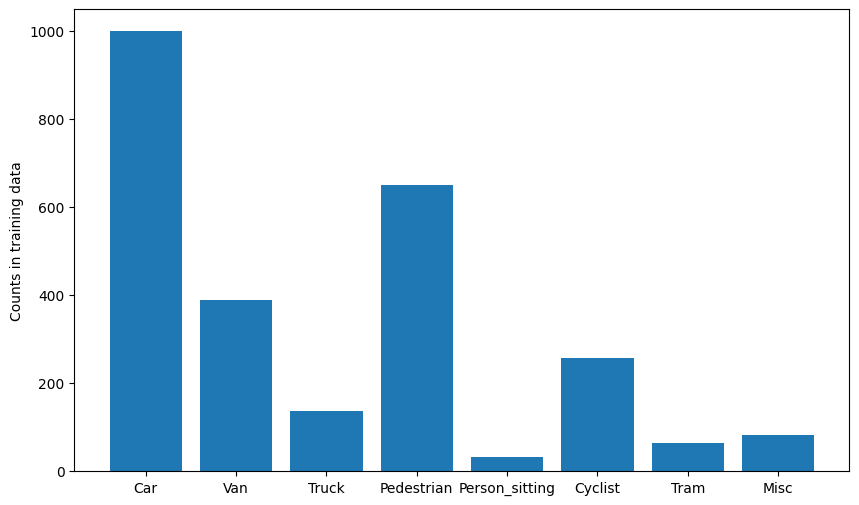

In [10]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

labels = list(train_ds.map(lambda x: x['label']).as_numpy_iterator())

classes, counts = np.unique(labels, return_counts=True)
plt.figure(figsize  = (10,6))
plt.ylabel('Counts in training data')
plt.bar(class_names, counts)

<BarContainer object of 6 artists>

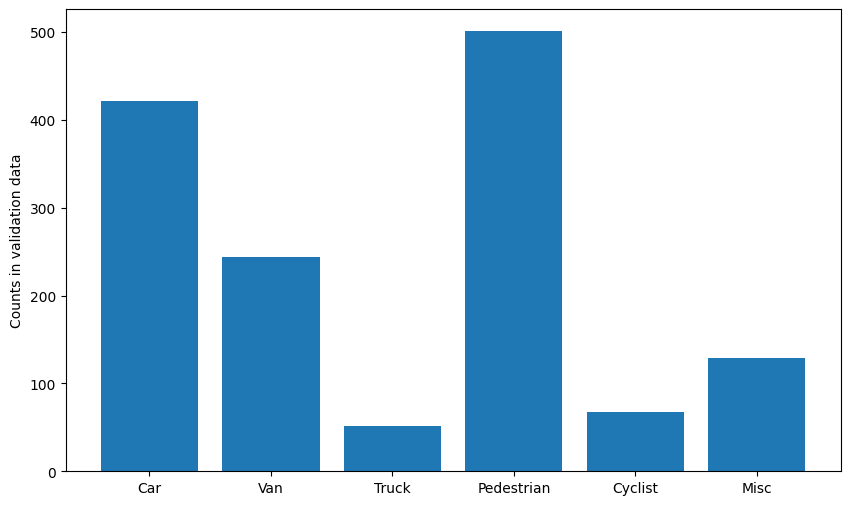

In [11]:
labels = list(valid_ds.map(lambda x: x['label']).as_numpy_iterator())

classes, counts = np.unique(labels, return_counts=True)
plt.figure(figsize  = (10,6))
plt.ylabel('Counts in validation data')
plt.bar(class_names[classes], counts)

> TODO: do something about data distribution, so it is more even.

Load feature vector of `mobilenet-v2` from HUB, and freeze the weights, so they are not trained:

In [13]:
IMAGE_RES = 224

URL = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-224-feature-vector/versions/2"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES,IMAGE_RES,3))

feature_extractor.trainable = False


Compose a new model, using `mobilenet-v2` feature vector as a backbone and 8 kitti-classes as output layer:

In [14]:
# there are 8 classes in kitti dataset
num_classes = dataset_info.features["objects"]["type"].num_classes
# Add classification to the backbone
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(num_classes)
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Augment data in the dataset and form batches:

In [15]:
resizer_rescaler = keras_cv.layers.Augmenter(
    [
        keras_cv.layers.Resizing(IMAGE_RES, IMAGE_RES, interpolation="bilinear"),
        keras_cv.layers.Rescaling(scale=1./255., offset=0.0)
    ],
)

augmenter = keras_cv.layers.Augmenter(
    [
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.RandAugment(value_range=(0, 255))
    ],
)

def preprocess_data(input, augment=False):
    image = input['image']
    image = resizer_rescaler(image)
    if augment:
        image = augmenter(image)
    return image, input['label']

Demonstration of data augmentation:

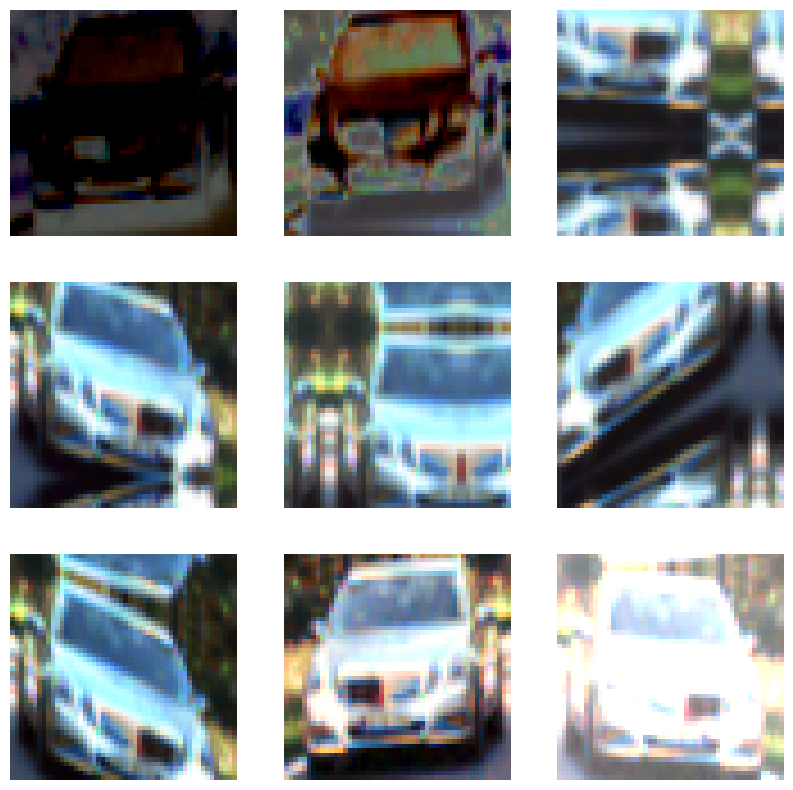

In [16]:
for elem in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = elem['image']
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = augmenter(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [17]:
BATCH_SIZE = 32

train_batches = train_ds.shuffle(len(train_ds)//4).map(lambda x: preprocess_data(x, augment=True)).batch(BATCH_SIZE).prefetch(1)
validation_batches = valid_ds.shuffle(len(valid_ds)//4).map(lambda x: preprocess_data(x, augment=False)).batch(BATCH_SIZE).prefetch(1)

Train the model:

In [18]:
EPOCHS = 10

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10


2024-03-11 16:29:30.387495: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-03-11 16:29:30.727789: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-11 16:29:33.318234: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x557dc3dd2a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-11 16:29:33.318289: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce MX250, Compute Capability 6.1
2024-03-11 16:29:33.337684: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-11 16:29:33.690401: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-11 16:29:33.800093: I ./tensorflow/compiler/jit/device_compile

82/82 [==============================] - 56s 601ms/step - loss: 1.5838 - accuracy: 0.4550 - val_loss: 1.4320 - val_accuracy: 0.5346
Epoch 2/10
82/82 [==============================] - 56s 682ms/step - loss: 1.5003 - accuracy: 0.4768 - val_loss: 1.3535 - val_accuracy: 0.5459
Epoch 3/10
82/82 [==============================] - 60s 732ms/step - loss: 1.4641 - accuracy: 0.4695 - val_loss: 1.3749 - val_accuracy: 0.5339
Epoch 4/10
82/82 [==============================] - 60s 734ms/step - loss: 1.4393 - accuracy: 0.5013 - val_loss: 1.2868 - val_accuracy: 0.5565
Epoch 5/10
82/82 [==============================] - 67s 816ms/step - loss: 1.4110 - accuracy: 0.5136 - val_loss: 1.1709 - val_accuracy: 0.6179
Epoch 6/10
82/82 [==============================] - 62s 757ms/step - loss: 1.3954 - accuracy: 0.5109 - val_loss: 1.1657 - val_accuracy: 0.6137
Epoch 7/10
82/82 [==============================] - 63s 771ms/step - loss: 1.4024 - accuracy: 0.5071 - val_loss: 1.1064 - val_accuracy: 0.6497
Epoch 8/10

Plot training and validation accuracy and loss:

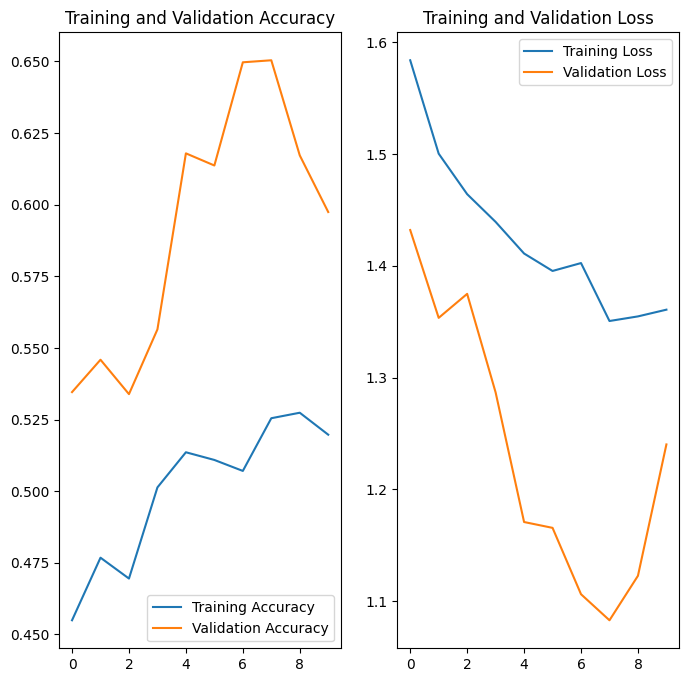

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Test this model's performance on new data using test dataset: 

In [20]:
test_batches = test_ds.shuffle(len(test_ds)//4).map(lambda x: preprocess_data(x, augment=False)).batch(BATCH_SIZE).prefetch(1)

image_batch, label_batch = next(iter(test_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
correct_class_names = class_names[label_batch]

# Print True Labels and Predicted Indices
print(predicted_ids)
print(label_batch)

1/1 [==============================] - 1s 504ms/step
[1 1 1 1 5 3 0 3 6 1 1 0 1 1 1 1 1 1 1 0 1 1 1 3 3 1 1 0 1 1 5 0]
[7 0 0 0 3 0 0 3 6 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 3 0 0 0 0 7 0 0]


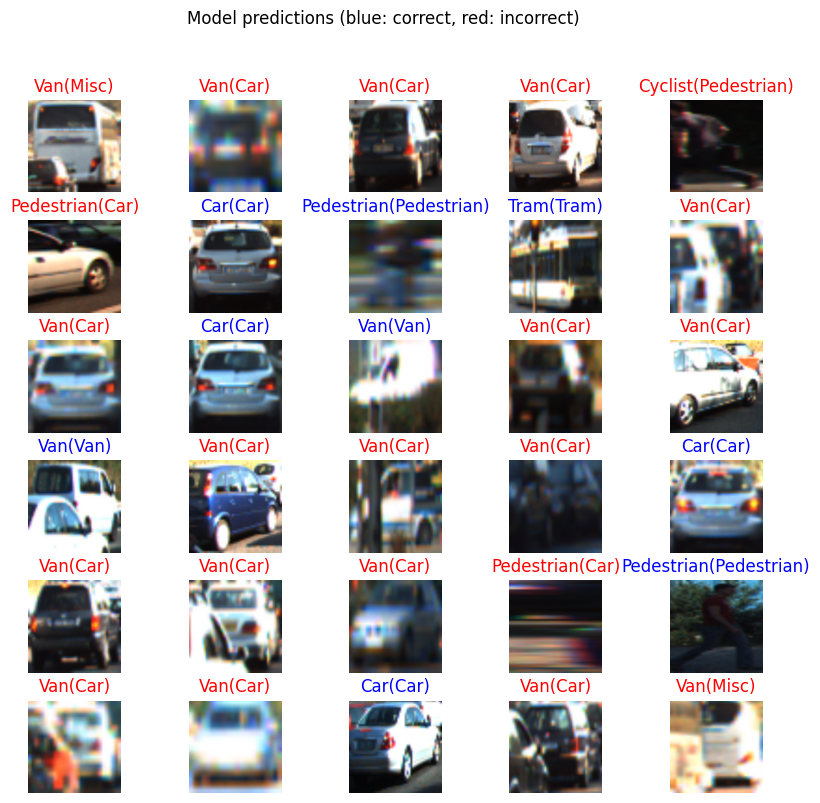

In [21]:
# Plot Model Predictions
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title() + '('+correct_class_names[n].title()+')', color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

Continue training the model:

In [43]:
ADD_EPOCHS = 10
TOTAL_EPOCHS =  EPOCHS + ADD_EPOCHS

history_fine = model.fit(train_batches,
                         epochs=TOTAL_EPOCHS,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_batches)

Epoch 6/16
171/171 [==============================] - 105s 614ms/step - loss: 0.9156 - accuracy: 0.7389 - val_loss: 0.8411 - val_accuracy: 0.7807
Epoch 7/16
171/171 [==============================] - 127s 741ms/step - loss: 0.9198 - accuracy: 0.7333 - val_loss: 0.8226 - val_accuracy: 0.7901
Epoch 8/16
171/171 [==============================] - 128s 752ms/step - loss: 0.9045 - accuracy: 0.7385 - val_loss: 0.7918 - val_accuracy: 0.7909
Epoch 9/16
171/171 [==============================] - 140s 817ms/step - loss: 0.9107 - accuracy: 0.7381 - val_loss: 0.8401 - val_accuracy: 0.7794
Epoch 10/16
171/171 [==============================] - 160s 936ms/step - loss: 0.9193 - accuracy: 0.7343 - val_loss: 0.8584 - val_accuracy: 0.7973
Epoch 11/16
171/171 [==============================] - 152s 891ms/step - loss: 0.8897 - accuracy: 0.7438 - val_loss: 0.8113 - val_accuracy: 0.7982
Epoch 12/16
171/171 [==============================] - 153s 895ms/step - loss: 0.8919 - accuracy: 0.7442 - val_loss: 0.806

In [44]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

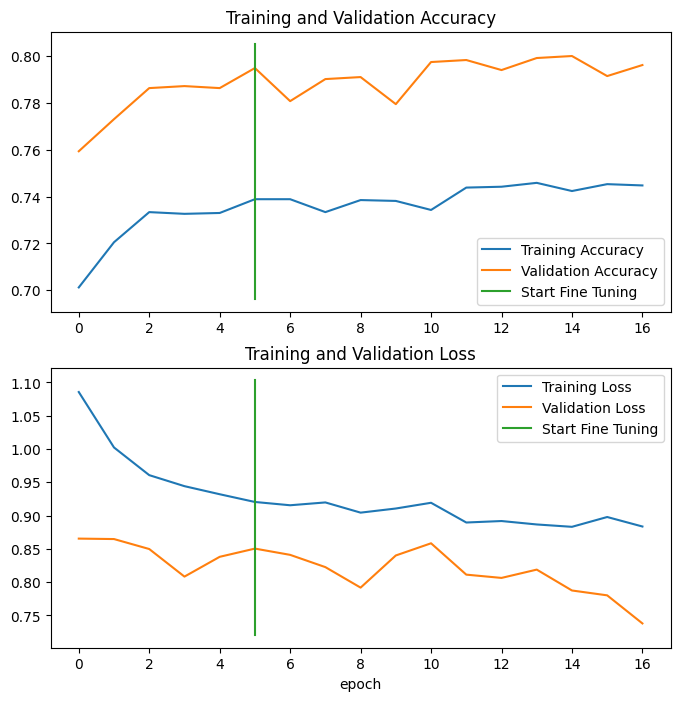

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()